# Lab Sheet 5 (COM3502-4502-6502 Speech Processing)

This lab sheet is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/Lab-Sheet-5.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

Let's download a wave file containing speech:

In [2]:
# download speech and noise example files
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  328k  100  328k    0     0   465k      0 --:--:-- --:--:-- --:--:--  464k


As done before several time by now, we can load it to a variable and play it back (if we like).

In [3]:
import soundfile as sf
from IPython import display as ipd

# load speech wave into variable
s, fs = sf.read(s_file_name)

print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

File "speech_8kHz_murder.wav" loaded. Its sampling rate is 8000 Hz.


## Spectrogram

The spectrogram can be used to visualise time and frequency information at the same time.

### Frequency Resolution vs. Time Resolution

The `specgram()` command from `matplotlib` has an optional parameter for the FFT length. Have a look at the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html) to familarise yourself with the parameters.

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 1:**
    
Create spectrograms of the speech signal `s` in different spectral and temporal resolution varying the parameters `NFFT` and `noverlap` of `matplotlib`'s `specgram()` command. 
    
</div>

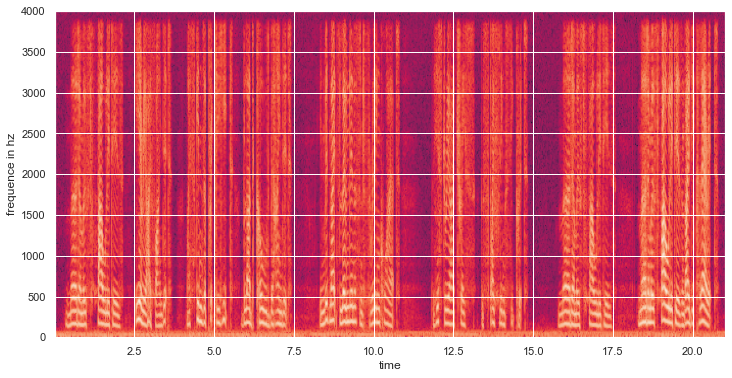

In [4]:
# your code here
# ...
fig = plt.figure(figsize=(12,6))
plt.specgram(s, Fs=fs,noverlap=256, NFFT=512)
plt.ylabel('frequence in hz')
plt.xlabel('time')
plt.show()

## Filtering by Piecewise Linear Filters

We want to design digital filters in the following as depited below:

<img src="https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Chp2Fundamentals/images/FilteringIIRfilter-web.svg" align="center"/>


This can be described mathematically by the difference equation for recursive filters 

\begin{equation}
y[k] = \sum_{m=0}^{q} b_m \; x[k-m] + \sum_{n=1}^{p} a_n \; y[k-n].
\end{equation}


### Tolerance Scheme

We want to design a piece-wise linear filter, such as a low-pass, band-pass, high-pass or similar, such filter shall at least fullfill the following conditions

*   It should be 1 or close to one in the pass-band area
*   It should be zero or close to zero in the stop band area

The following function `plot_tolerance_scheme()` is a helper function which visualises such a tolerance scheme. 

The following conditions are visualised in the tolerance scheme below for the exmample values $\omega_p=0.25$, $\omega_s=0.3$, and allowing for 10% ripples both in stop band area as in pass band area. The allowed tolerance is the pass-band area is defined by the parameter `Rp_lin`, and allowed tolerance is the stop-band area by `Rs_lin`. Please note, that they have the ending `..._lin` since we will need these quantities later in logarithmic scaling (we will care for this then). 

In [5]:
def plot_tolerance_scheme(wp=0.25,ws=0.3,Rp_lin=0.9,Rs_lin=0.1):
    ''' plot limits '''
    dh1x=[0,ws];  dh1y=[1,1];     
    dh2x=[0,wp];  dh2y=[Rp_lin,Rp_lin]; 
    dv2x=[wp,wp]; dv2y=[0,Rp_lin];   
    sh1x=[ws,1];  sh1y=[Rs_lin,Rs_lin]; 
    sh2x=[wp,1];  sh2y=[0,0]; 
    svx=[ws,ws];  svy=[Rs_lin,1];  
    plt.plot(dh1x,dh1y,'k--',dh2x,dh2y,'k--',dv2x,dv2y,'k--',sh1x,sh1y,'k--',
             sh2x,sh2y,'k--',svx,svy,'k--');
    plt.xlabel('Frequency $\Omega/\pi$');

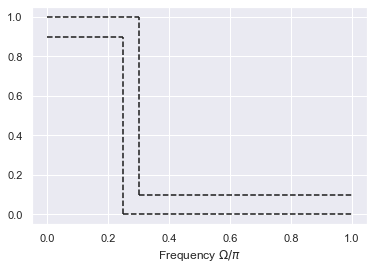

In [6]:
wp=0.25;    # passband edge frequency 
ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area

plot_tolerance_scheme()

Please note that the low pass tolerance scheme is given in terms of normalised frequency $\Omega$.

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 2:**

Generate a tolerance scheme for a low-pass which should let pass half of the frequency region between $f=0$ and $f_{\mathrm{max}}=4000$ Hz and allows ripples of $5 \%$ as well for pass-band as in stop-band.
    
</div>

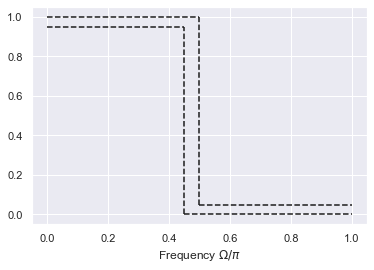

In [7]:
# your code here
#
# ...
ws = 0.450  ###ws and wp is stopband and passband area, the question mentioned should let pass half of the frequency region 
wp = 0.500  ###so it should around 4 to 5 whatever you wanna defined
Rp_lin = 0.95 ### Rp_lin and Rs_lin means the ripples of percentage we allows,the question mentioned 5%, so we should make it plus together
Rs_lin = 0.05 ### equal to 1 and differ 0.05

plot_tolerance_scheme(ws, wp,Rp_lin, Rs_lin)

### Zero-Pole Plot (Transfer Functuon of Filters in z-Domain)

Applying a $z$-transform to the difference equation $z$-domain transfer function $H(z)$ of the filter leads to

\begin{equation}
H(z) = \frac{Y(z)}{X(z)} = \frac{\sum_{m=0}^{M} b_m \, z^{-m}}{\sum_{n=0}^{N} a_n \, z^{-n}}
\end{equation}

The transfer function can also be extpressed in term of the positions of its $P$ zeros $z_{0,\mu}$, ($1 \leq \mu \leq P$) and  its $Q$ poles $z_{\infty,\nu}$, ($1 \leq \nu \leq Q$). 


\begin{equation}
H(z) = \frac{b_M}{a_N} \cdot \frac{\prod_{\mu=1}^{P} (z - z_{0,\mu})^{m_\mu}}{\prod_{\nu=1}^{Q} (z - z_{\infty,\nu})^{n_\nu}}
\end{equation}

For speech and audio processing, systems often have real-valued coefficients $b_m\in\mathbb{R}$ and $a_n\in\mathbb{R}$ which results in a real-valued system. For real-valued systems, poles and zeros are either real valued or occur in complex conjugate pairs.

For the poles of a *causal* and *stable* system $H(z)$ all poles have to lie within the unit circle, i.e. $|z| = 1$. 

In [8]:
def zplane(z, p, title='Poles and Zeros'):
    "Plots zeros and poles in the complex z-plane"
    ax = plt.gca() ###Get the current axes, creating one if necessary.

    ax.plot(np.real(z), np.imag(z), 'bo', fillstyle='none', ms=10)
    ax.plot(np.real(p), np.imag(p), 'rx', fillstyle='none', ms=10)
    unit_circle = plt.Circle((0, 0), radius=1, fill=False,
                             color='black', ls='--', alpha=0.9)
    ax.add_patch(unit_circle) ###Add a Patch to the axes' patches; return the patch.

    plt.title(title)
    plt.xlabel('Re{$z$}')
    plt.ylabel('Im{$z$}')
    plt.axis('equal')

The code below exemplarily shows two (conjugate complex共轭复数) zeros at positions $z_{0,1}= -0.9$ and $z_{0,2} = 0.8$ (indicated by the blue circles) as well as a poles at positions $z_{\infty,1}=0.5 + 0.5j$ and $z_{\infty,2}=0.5 - 0.5j$ (indicated by the red crosses)  in the $z$ plane. The code above is a helper-function to plot the zeros and poles.

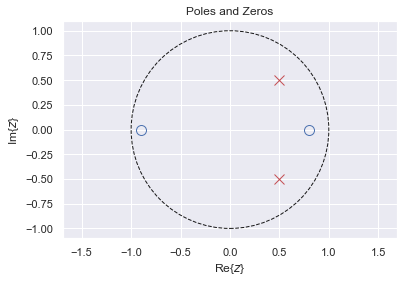

In [9]:
poles = [0.5-0.5j, 0.5+0.5j] # two (comjugate complex) poles
zeros = [-0.9, 0.8]          # two (real-valued) zeros
zplane(zeros,poles)

### Butterworth Filter Design

In [10]:
from scipy import signal         # filter designs

In [11]:
# the ripple hights in dB are needed in later cells of this Jupyter Notebook 
Rp=-20*np.log10(Rp_lin);  # max passband ripple in dB
Rs=-20*np.log10(Rs_lin);  # min stopband attenuation in dB

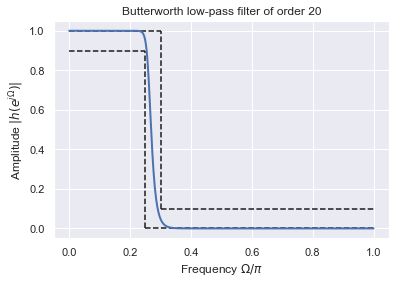

In [12]:
wp=0.25;    # passband edge frequency 
ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area
# get lowest filter order N to fullfill requirements above
N, Wn = signal.buttord(wp, ws, Rp, Rs) ###Butterworth filter order selection.
# design low-pass filter of order N using butterworth method
b, a = signal.butter(N, Wn, 'low') ###Butterworth digital and analog filter design.Butterworth数字和模拟滤波器设计 

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plot_tolerance_scheme(wp,ws,Rp_lin,Rs_lin)
plt.plot(omega, abs(h), lw=2)
plt.title('Butterworth low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$');

The complex potions of the poles and zeros can be calculated using numpy's function `root()`. 

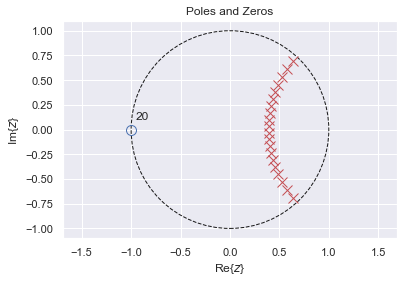

In [13]:
# plot zeros and poles in the z plane
zplane(-1, np.roots(a)) ### np.roots(p) p is Wn fo signal.buttord, 
                        ###is array_like, Rank-1 array of polynomial coefficients.多项式系数的秩1数组。
plt.text(-0.95,0.1,str(N));

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 3:**
    
Create a butterwort filter fullfilling the tolerance scheme created for Task 2.
    
</div>

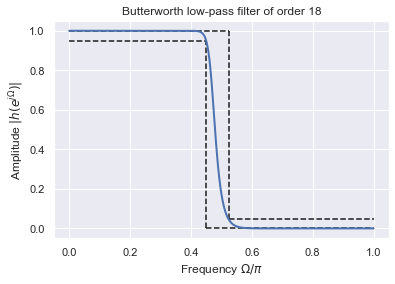

In [14]:
# your code here
#
# ...
wp = 0.450  
ws = 0.525  
Rp_lin = 0.95 
Rs_lin = 0.05 

# the ripple hights in dB are needed in later cells of this Jupyter Notebook 
Rp=-20*np.log10(Rp_lin);  # max passband ripple in dB
Rs=-20*np.log10(Rs_lin);  # min stopband attenuation in dB

# get lowest filter order N to fullfill requirements above
N, Wn = signal.buttord(wp, ws, Rp, Rs) ###Butterworth filter order selection.
# design low-pass filter of order N using butterworth method
b, a = signal.butter(N, Wn, 'low') ###Butterworth digital and analog filter design.Butterworth数字和模拟滤波器设计 

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plot_tolerance_scheme(wp, ws,Rp_lin, Rs_lin)
plt.plot(omega, abs(h), lw=2)
plt.title('Butterworth low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$');



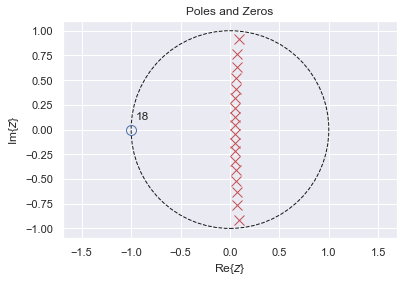

In [15]:
# plot zeros and poles in the z plane
zplane(-1, np.roots(a)) ### np.roots(p) p is Wn fo signal.buttord, 
                        ###is array_like, Rank-1 array of polynomial coefficients.多项式系数的秩1数组。
plt.text(-0.95,0.1,str(N));

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 4:**
    
Apply the filter you designed using the function `signal.filtfilt()`. Visualise the signal before and after filtering and plot the spectra.
    
</div>

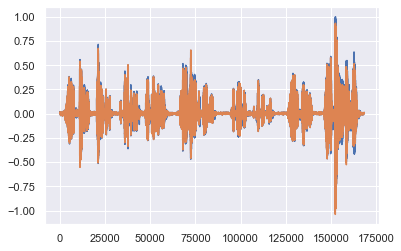

In [16]:
# your code here
#
# ... 
s_filted = signal.filtfilt(b,a,s)  ###the parameters are equal the first parameter return from signal.filtfilt(b,a,s)  ###
plt.plot(s)
plt.plot(s_filted)

### Chebyshev I and Chebyshev II filter design

Chebyshev filter designs make better use of the tolerance scheme by allowing for ripples in the pass band (Chebyshev I filter design) or stop band (Chebyshev II filter design), respectively. By this, the number of necessary filter coefficients $N$ can be reduced in comparison to the Butterworth filter.


<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 5:**
    
Design a Chebyshev I and Chebyshev II filter. You might find the functions `signal.cheb1ord`, `signal.cheby2`, `signal.cheb1ord` and `signal.cheby2` helpful for this.
    
</div>

0.25 0.3 0.9151498112135024 20.0
0.25 0.3 0.9151498112135024 20.0


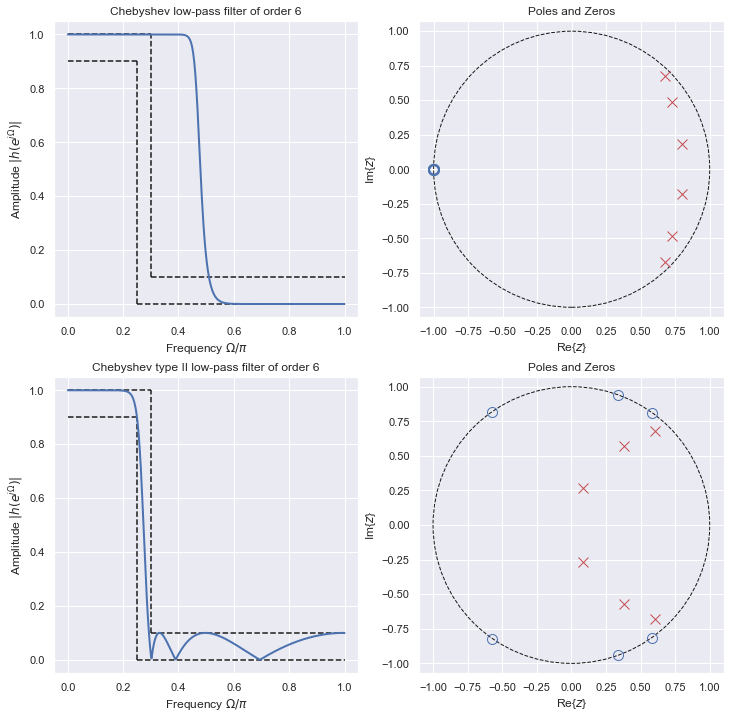

In [17]:
# your code here
#
# ...
wp=0.25;    # passband edge frequency 
ws=0.30;    # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area

Rp=-20*np.log10(Rp_lin);  # max passband ripple in dB
Rs=-20*np.log10(Rs_lin);  # min stopband attenuation in dB

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
# get lowest filter order N to fullfill requirements above
N, Wn = signal.cheb1ord(wp, ws, Rp, Rs) ###Chebyshev I filter order selection.
# design low-pass filter of order N using cheby2 method
print(wp,ws,Rp,Rs)
b, a = signal.cheby1(N, Rp, Wn, 'low') ###ChebyshevI digital and analog filter design.Butterworth Chebyshev I型数字和模拟滤波器设计。 

plot_tolerance_scheme(wp,ws,Rp_lin,Rs_lin)
plt.plot(omega, abs(h), lw=2)

plt.title('Chebyshev low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$');
# plt.show()


plt.subplot(2,2,2)
# plot zeros and poles in the z plane
zplane(np.roots(b), np.roots(a)) ### np.roots(p) p is Wn fo signal.buttord, 
                        ###is array_like, Rank-1 array of polynomial coefficients.多项式系数的秩1数组。



N, Wn = signal.cheb2ord(wp, ws, Rp, Rs) ###Chebyshev II filter order selection.
print(wp,ws,Rp,Rs)
# design low-pass filter of order N using cheby2 method
b, a = signal.cheby2(N, Rs, Wn, 'low') ###ChebyshevII digital and analog filter design.Butterworth Chebyshev II型数字和模拟滤波器设计。 

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

plt.subplot(2,2,3)
plot_tolerance_scheme(wp, ws,Rp_lin, Rs_lin)
plt.plot(omega, abs(h), lw=2)
plt.title('Chebyshev type II low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$')

plt.subplot(2,2,4)
# plot zeros and poles in the z plane
zplane(np.roots(b), np.roots(a)) ### np.roots(p) p is Wn fo signal.buttord, 
                        ###is array_like, Rank-1 array of polynomial coefficients.多项式系数的秩1数组。


### Cauer Filter a.k.a. Elliptical Filter Design

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 6:**
    
Design a Cauer filter. You might find the functions `signal.ellipord` and `signal.ellip` helpful for this.
</div>


0.25 0.3 0.9151498112135024 20.0


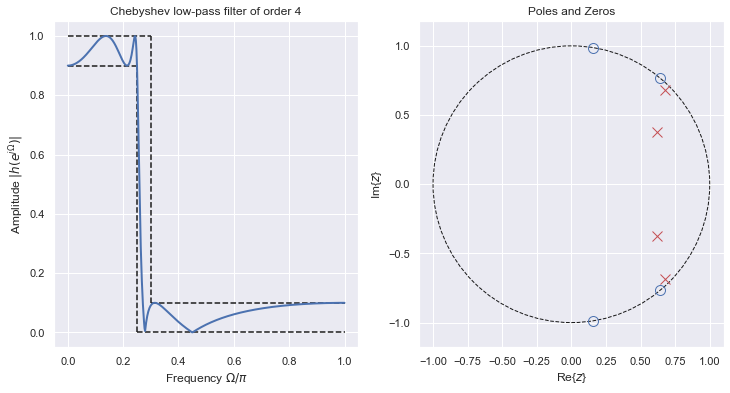

In [19]:
# your code here
#
# ...



plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
# get lowest filter order N to fullfill requirements above
N, Wn = signal.ellipord(wp, ws, Rp, Rs) ###Chebyshev I filter order selection.
# design low-pass filter of order N using cheby2 method
print(wp,ws,Rp,Rs)
b, a = signal.ellip(N, Rp, Rs, Wn, 'low') ###ChebyshevI digital and analog filter design.Butterworth Chebyshev I型数字和模拟滤波器设计。 
h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

plot_tolerance_scheme(wp,ws,Rp_lin,Rs_lin)
plt.plot(omega, abs(h), lw=2)

plt.title('Chebyshev low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$');
# plt.show()


plt.subplot(1,2,2)
# plot zeros and poles in the z plane
zplane(np.roots(b), np.roots(a)) ### np.roots(p) p is Wn fo signal.buttord, 
                        ###is array_like, Rank-1 array of polynomial coefficients.多项式系数的秩1数组。


### Band pass and plotting in dB

Filters (especially for processing speech or music) are usually not only designed with logarithmic amplitude in mind, but also plotted with linear amplitude.

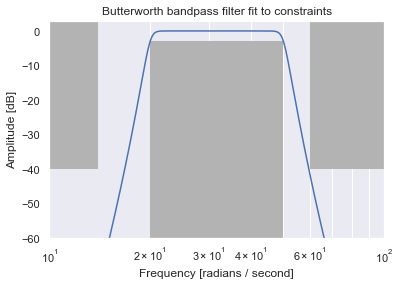

In [20]:
N, Wn = signal.buttord([20, 50], [14, 60], 3, 40, True)
b, a = signal.butter(N, Wn, 'band', True) ### When True, return an analog filter模拟滤波器, otherwise a digital filter is returned. 
w, h = signal.freqs(b, a, np.logspace(1, 2, 500)) ###Compute frequency response of analog filter.
### b:Numerator分子 of a linear filter. a:Denominator分母 of a linear filter.
###第三个参数 worN 如果为“无”，则以响应曲线的有趣部分(由pole-zero位置确定)周围的200个频率进行计算。如果是

plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth bandpass filter fit to constraints')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both') ###Configure the grid lines. 
### which:{'major', 'minor', 'both'}:The grid lines to apply the changes on.
###axis : {'both', 'x', 'y'}, The axis to apply the changes on.
plt.fill([1,  14,  14,   1], [-40, -40, 99, 99], '0.7', lw=0) # stop  ### Plot filled polygons.绘制多边形
plt.fill([20, 20,  50,  50], [-99, -3, -3, -99], '0.7', lw=0) # pass
plt.fill([60, 60, 1e9, 1e9], [99, -40, -40, 99], '0.7', lw=0) # stop
plt.axis([10, 100, -60, 3]);

<br>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 7:**
    
Filter the signal by the bandpass designed above and listen to it. Again, you could visualise what you hear by using the spectrogram.
    
</div>

0.01 0.8912509381337456


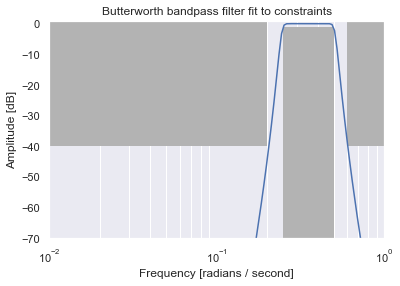

In [21]:
# your code here
#
# ...
Wp = [0.25, 0.50]
Ws = [0.20, 0.60]
Rp = 1
Rs = 40
Rs_lin= 10**(-Rs/20)
Rp_lin= 10**(-Rp/20)
print(Rs_lin, Rp_lin)

N, Wn = signal.buttord(Wp, Ws, Rp, Rs)

b, a = signal.butter(N, Wn, 'band', True) ### When True, return an analog filter模拟滤波器, otherwise a digital filter is returned. 
w, h = signal.freqs(b, a) 
omega=np.linspace(0,1,len(w))


plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth bandpass filter fit to constraints')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both') ###Configure the grid lines. 
### which:{'major', 'minor', 'both'}:The grid lines to apply the changes on.
###axis : {'both', 'x', 'y'}, The axis to apply the changes on.
plt.fill([0,  Ws[0],  Ws[0],   0], [-Rs, -Rs, 2, 2], '0.7', lw=0) # stop  ### Plot filled polygons.绘制多边形
plt.fill([Wp[0], Wp[0],  Wp[1],  Wp[1]], [-100, -Rp, -Rp, -100], '0.7', lw=0) # pass
plt.fill([Ws[1], Ws[1], 1, 1], [2, -Rs, -Rs, 2], '0.7', lw=0) # stop
plt.axis([0.01, 1, -70, 1]);



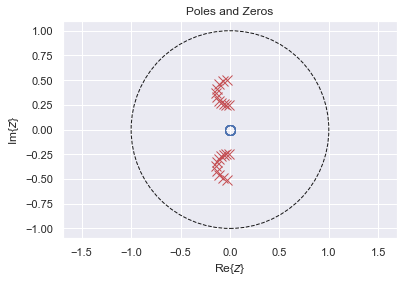

In [22]:
zplane(np.roots(b), np.roots(a))


## Copyright

This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 